<a href="https://www.kaggle.com/code/albertobircoci/boosting-models?scriptVersionId=256150712" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 

df = pd.read_csv("/kaggle/input/support-ticket-priority-dataset-50k/Support_tickets.csv")
df.head(3)


,ticket_id,day_of_week,day_of_week_num,company_id,company_size,company_size_cat,industry,industry_cat,customer_tier,customer_tier_cat,...,downtime_min,payment_impact_flag,security_incident_flag,data_loss_flag,has_runbook,customer_sentiment,customer_sentiment_cat,description_length,priority,priority_cat
0,1000000000,Wed,3,100015,Small,1,media,7,Basic,1,...,6,0,0,0,0,neutral,2,227,low,1
1,1000000001,Sat,6,100023,Small,1,healthcare,5,Basic,1,...,2,0,0,0,0,neutral,2,461,low,1
2,1000000002,Mon,1,100012,Small,1,gaming,4,Basic,1,...,0,0,0,0,1,positive,3,306,low,1


In [2]:
df.shape

(50000, 33)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ticket_id               50000 non-null  int64  
 1   day_of_week             50000 non-null  object 
 2   day_of_week_num         50000 non-null  int64  
 3   company_id              50000 non-null  int64  
 4   company_size            50000 non-null  object 
 5   company_size_cat        50000 non-null  int64  
 6   industry                50000 non-null  object 
 7   industry_cat            50000 non-null  int64  
 8   customer_tier           50000 non-null  object 
 9   customer_tier_cat       50000 non-null  int64  
 10  org_users               50000 non-null  int64  
 11  region                  50000 non-null  object 
 12  region_cat              50000 non-null  int64  
 13  past_30d_tickets        50000 non-null  int64  
 14  past_90d_incidents      50000 non-null

In [4]:
num_df = df.select_dtypes(include=["number"]).copy()
num_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ticket_id               50000 non-null  int64  
 1   day_of_week_num         50000 non-null  int64  
 2   company_id              50000 non-null  int64  
 3   company_size_cat        50000 non-null  int64  
 4   industry_cat            50000 non-null  int64  
 5   customer_tier_cat       50000 non-null  int64  
 6   org_users               50000 non-null  int64  
 7   region_cat              50000 non-null  int64  
 8   past_30d_tickets        50000 non-null  int64  
 9   past_90d_incidents      50000 non-null  int64  
 10  product_area_cat        50000 non-null  int64  
 11  booking_channel_cat     50000 non-null  int64  
 12  reported_by_role_cat    50000 non-null  int64  
 13  customers_affected      50000 non-null  int64  
 14  error_rate_pct          50000 non-null

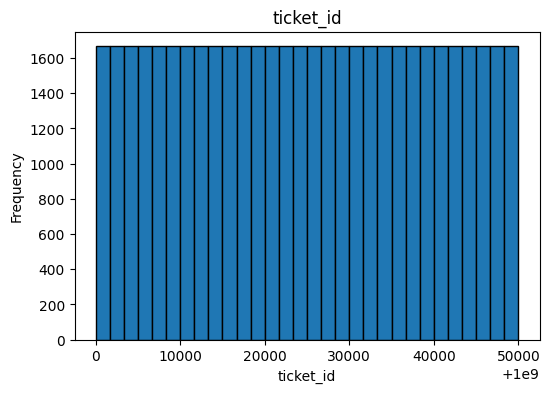

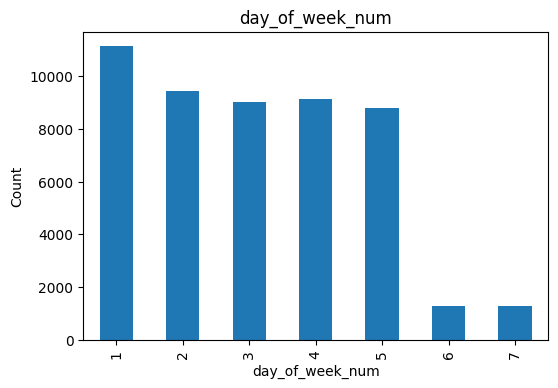

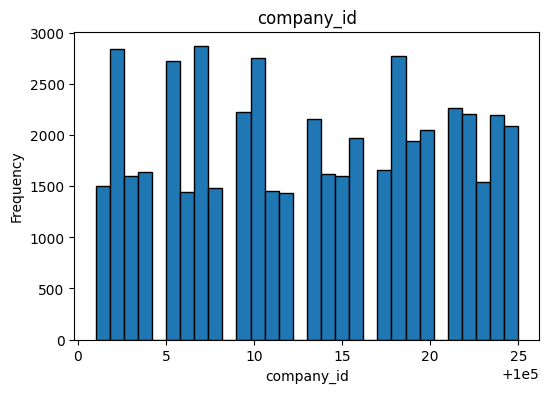

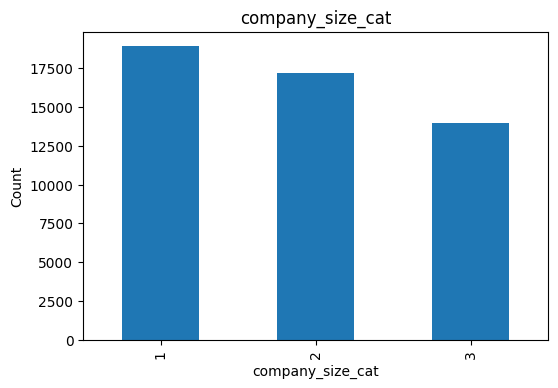

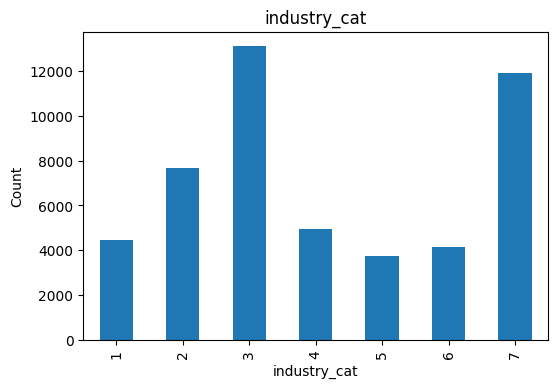

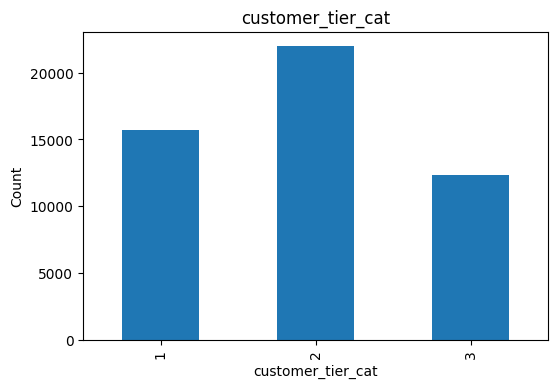

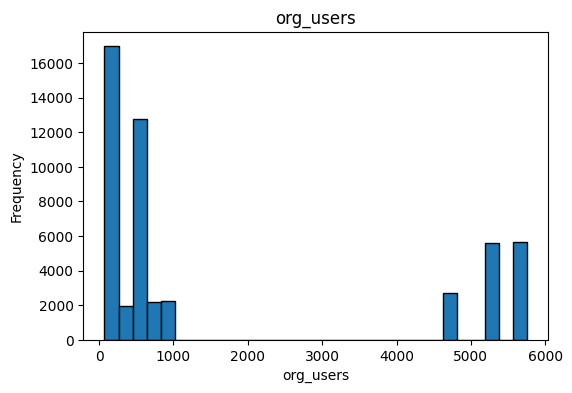

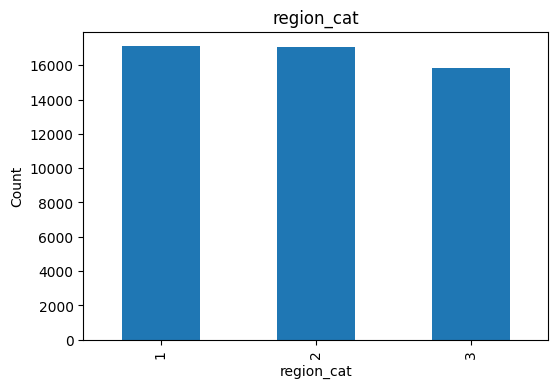

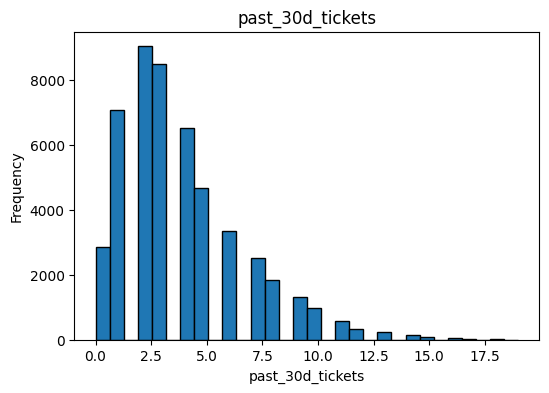

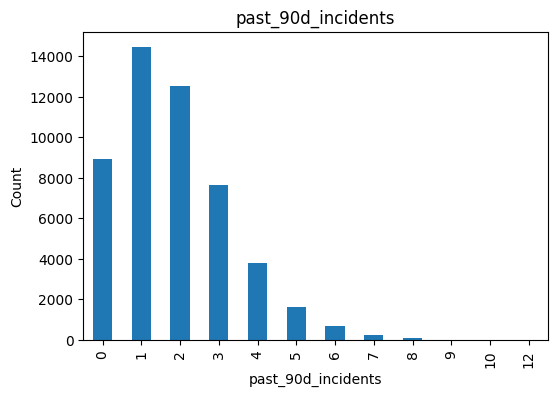

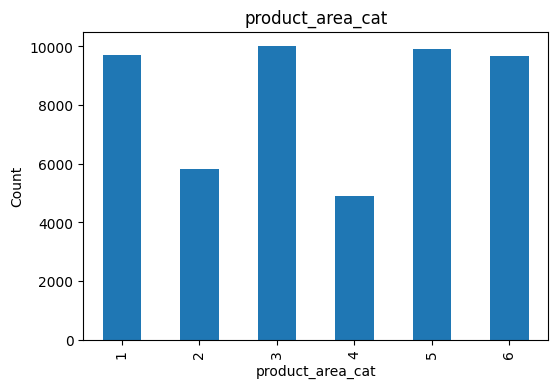

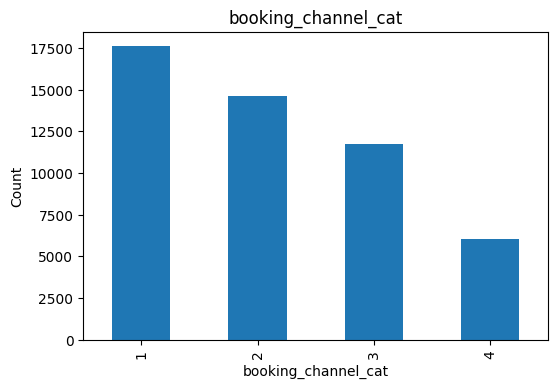

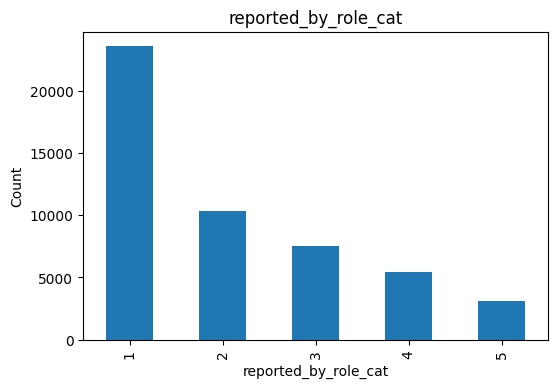

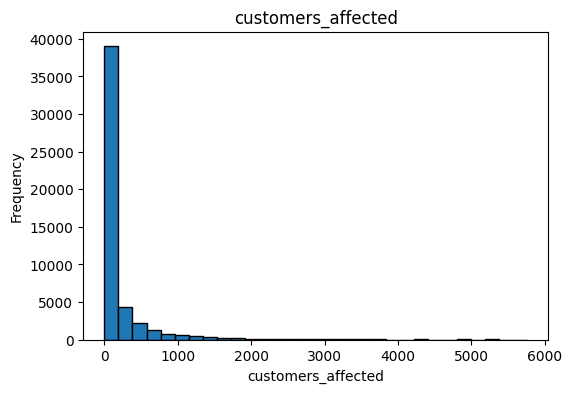

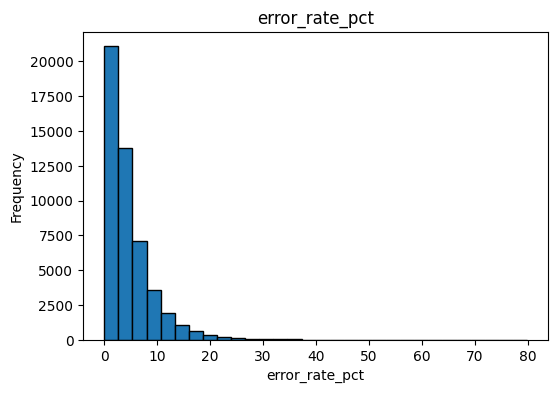

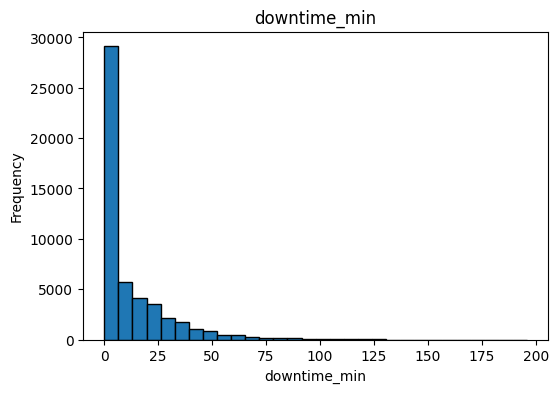

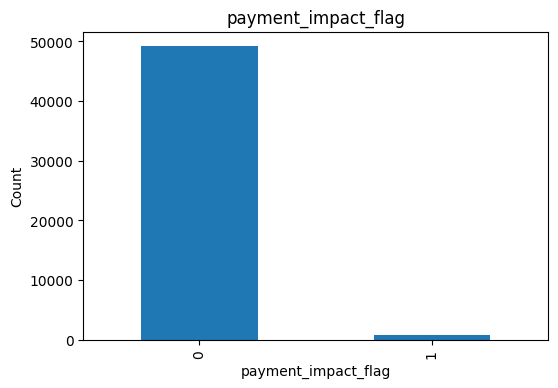

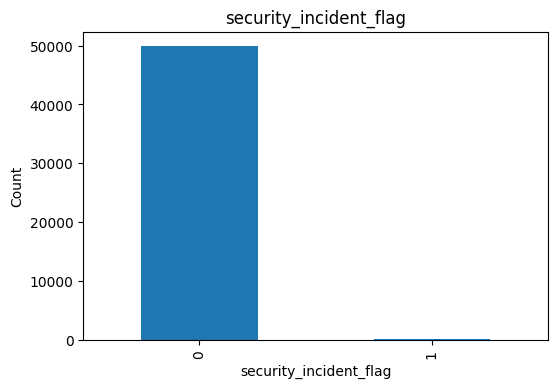

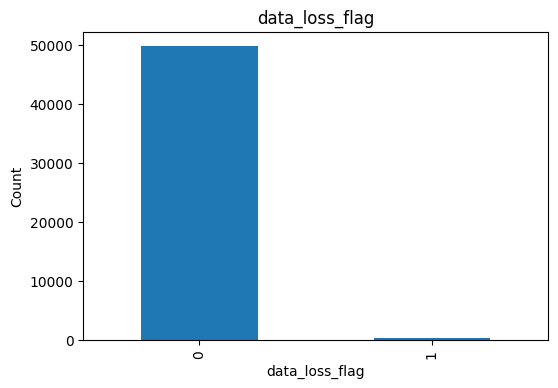

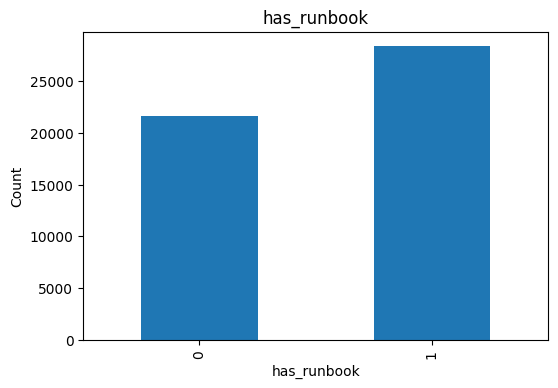

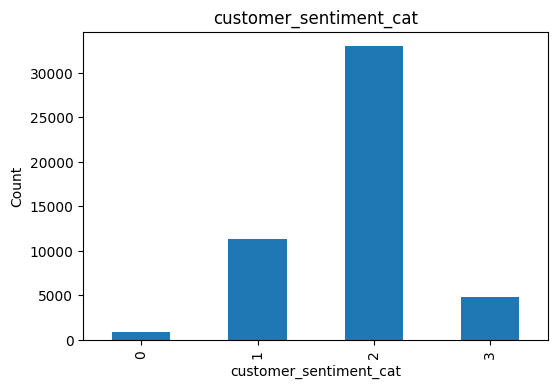

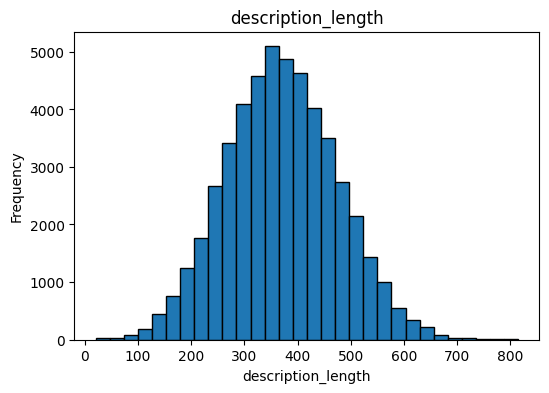

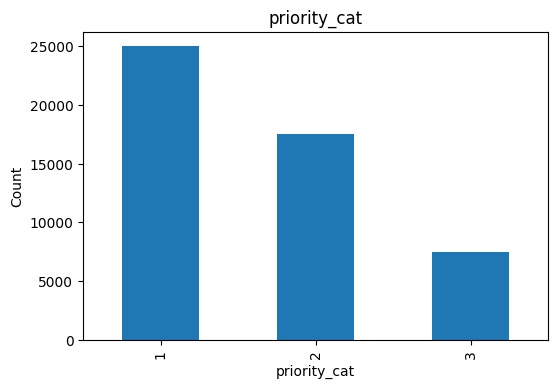

In [5]:
import matplotlib.pyplot as plt

for col in num_df.columns:
    plt.figure(figsize=(6,4))
    if num_df[col].nunique() <= 15:
        num_df[col].value_counts().sort_index().plot(kind="bar")
        plt.ylabel("Count")
    else:
        num_df[col].plot(kind="hist", bins=30, edgecolor="black")
        plt.ylabel("Frequency")
    plt.title(col)
    plt.xlabel(col)
    plt.show()


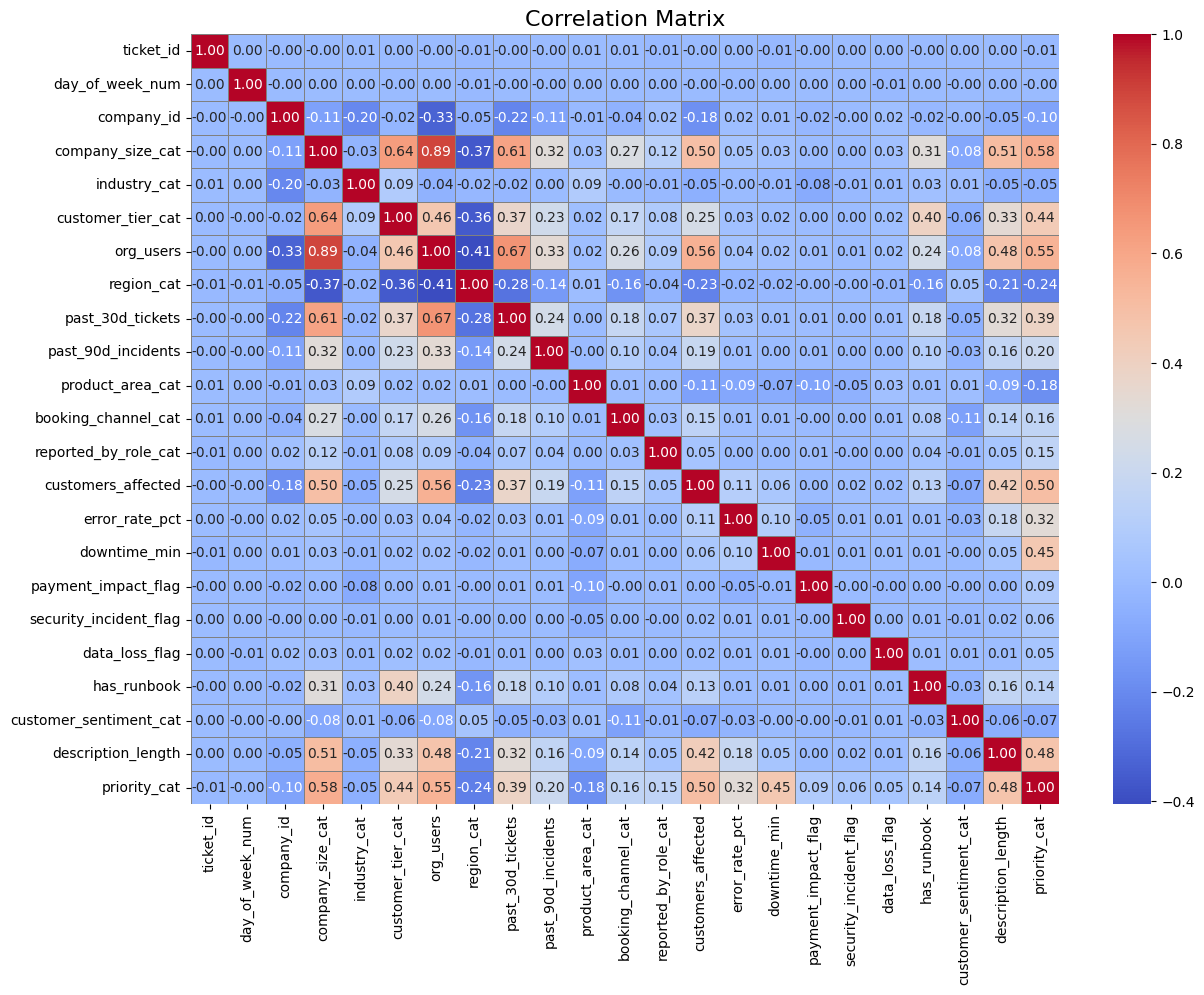

In [6]:
import seaborn as sns

corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(14,10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray",
    cbar=True
)
plt.title("Correlation Matrix", fontsize=16)
plt.show()


In [7]:
from sklearn.model_selection import ShuffleSplit

X = num_df.drop(columns=["priority_cat"])
y = num_df["priority_cat"].astype(int) - 1 

splits = []
rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_idx, test_idx in rs.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    splits.append((X_train, X_test, y_train, y_test))

for i, (Xtr, Xte, ytr, yte) in enumerate(splits, start=1):
    print(f"Split {i}: Train={Xtr.shape}, Test={Xte.shape}")


Split 1: Train=(40000, 22), Test=(10000, 22)
Split 2: Train=(40000, 22), Test=(10000, 22)
Split 3: Train=(40000, 22), Test=(10000, 22)
Split 4: Train=(40000, 22), Test=(10000, 22)
Split 5: Train=(40000, 22), Test=(10000, 22)


In [8]:
import numpy as np
import pandas as pd
from time import perf_counter
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

SEED = 2025
X = num_df.drop(columns=["priority_cat"])
y = num_df["priority_cat"].values - 1  # 0,1,2

rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)
results = []

def eval_model(clf, Xtr, Xte, ytr, yte, xgb_like=False):
    t0 = perf_counter()
    if xgb_like:
        clf.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    else:
        clf.fit(Xtr, ytr)
    t1 = perf_counter()
    p = clf.predict(Xte)
    t2 = perf_counter()
    proba = clf.predict_proba(Xte)
    acc = accuracy_score(yte, p)
    f1m = f1_score(yte, p, average="macro")
    auc = roc_auc_score(yte, proba, multi_class="ovr")
    return acc, f1m, auc, (t1 - t0), (t2 - t1), (t2 - t0)

for i, (tr, te) in enumerate(rs.split(X), start=1):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    ytr, yte = y[tr], y[te]

    gb = GradientBoostingClassifier(random_state=SEED, n_estimators=800, learning_rate=0.05)
    acc,f1m,auc,fit_s,pred_s,total_s = eval_model(gb, Xtr, Xte, ytr, yte)
    results.append({"model":"GradientBoosting","split":i,"accuracy":acc,"f1_macro":f1m,"auc_ovr":auc,
                    "fit_s":fit_s,"pred_s":pred_s,"total_s":total_s})
    print(f"✅ Split {i} - GradientBoosting done in {total_s:.2f}s (fit {fit_s:.2f}s, pred {pred_s:.2f}s)")

    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=SEED),
                             n_estimators=1000, learning_rate=0.05, random_state=SEED)
    acc,f1m,auc,fit_s,pred_s,total_s = eval_model(ada, Xtr, Xte, ytr, yte)
    results.append({"model":"AdaBoost","split":i,"accuracy":acc,"f1_macro":f1m,"auc_ovr":auc,
                    "fit_s":fit_s,"pred_s":pred_s,"total_s":total_s})
    print(f"✅ Split {i} - AdaBoost done in {total_s:.2f}s (fit {fit_s:.2f}s, pred {pred_s:.2f}s)")

    xgb = XGBClassifier(objective="multi:softprob", num_class=3, n_estimators=3000,
                        learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8,
                        tree_method="hist", eval_metric="mlogloss", random_state=SEED,
                        early_stopping_rounds=150, n_jobs=-1)
    acc,f1m,auc,fit_s,pred_s,total_s = eval_model(xgb, Xtr, Xte, ytr, yte, xgb_like=True)
    results.append({"model":"XGBoost","split":i,"accuracy":acc,"f1_macro":f1m,"auc_ovr":auc,
                    "fit_s":fit_s,"pred_s":pred_s,"total_s":total_s})
    print(f"✅ Split {i} - XGBoost done in {total_s:.2f}s (fit {fit_s:.2f}s, pred {pred_s:.2f}s)")

    lgbm = LGBMClassifier(objective="multiclass", num_class=3, n_estimators=5000,
                          learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
                          random_state=SEED, verbose=-1, n_jobs=-1)
    acc,f1m,auc,fit_s,pred_s,total_s = eval_model(lgbm, Xtr, Xte, ytr, yte)
    results.append({"model":"LightGBM","split":i,"accuracy":acc,"f1_macro":f1m,"auc_ovr":auc,
                    "fit_s":fit_s,"pred_s":pred_s,"total_s":total_s})
    print(f"✅ Split {i} - LightGBM done in {total_s:.2f}s (fit {fit_s:.2f}s, pred {pred_s:.2f}s)")

results_df = pd.DataFrame(results).sort_values(["model","split"]).round(4)
results_df


✅ Split 1 - GradientBoosting done in 205.97s (fit 205.61s, pred 0.35s)
✅ Split 1 - AdaBoost done in 60.90s (fit 59.66s, pred 1.24s)
✅ Split 1 - XGBoost done in 30.33s (fit 29.73s, pred 0.60s)
✅ Split 1 - LightGBM done in 46.18s (fit 41.31s, pred 4.87s)
✅ Split 2 - GradientBoosting done in 205.05s (fit 204.70s, pred 0.35s)
✅ Split 2 - AdaBoost done in 61.71s (fit 60.44s, pred 1.27s)
✅ Split 2 - XGBoost done in 26.16s (fit 25.63s, pred 0.53s)
✅ Split 2 - LightGBM done in 45.70s (fit 40.80s, pred 4.90s)
✅ Split 3 - GradientBoosting done in 205.18s (fit 204.83s, pred 0.35s)
✅ Split 3 - AdaBoost done in 64.34s (fit 63.06s, pred 1.28s)
✅ Split 3 - XGBoost done in 29.99s (fit 29.38s, pred 0.61s)
✅ Split 3 - LightGBM done in 46.73s (fit 41.12s, pred 5.61s)
✅ Split 4 - GradientBoosting done in 205.60s (fit 205.25s, pred 0.35s)
✅ Split 4 - AdaBoost done in 63.27s (fit 61.95s, pred 1.31s)
✅ Split 4 - XGBoost done in 28.87s (fit 28.30s, pred 0.57s)
✅ Split 4 - LightGBM done in 47.35s (fit 42.56s, 

,model,split,accuracy,f1_macro,auc_ovr,fit_s,pred_s,total_s
1,AdaBoost,1,0.8653,0.8166,0.9183,59.6585,1.2442,60.9026
5,AdaBoost,2,0.8699,0.8213,0.9193,60.4373,1.2734,61.7107
9,AdaBoost,3,0.8571,0.8115,0.9058,63.0645,1.2804,64.3449
13,AdaBoost,4,0.8629,0.8095,0.9115,61.9534,1.3150,63.2684
17,AdaBoost,5,0.8663,0.8181,0.9125,60.4155,1.2881,61.7036
0,GradientBoosting,1,0.9721,0.9683,0.9984,205.6149,0.3502,205.9651
4,GradientBoosting,2,0.9719,0.9679,0.9983,204.7012,0.3489,205.0501
8,GradientBoosting,3,0.9727,0.9674,0.9981,204.8255,0.3508,205.1764
12,GradientBoosting,4,0.9740,0.9693,0.9983,205.2521,0.3518,205.6040
16,GradientBoosting,5,0.9703,0.9653,0.9978,204.9086,0.3521,205.2608


In [9]:
res = results_df.copy()

metric = "auc_ovr"  # or "accuracy" / "f1_macro"
winners = res.loc[res.groupby("split")[metric].idxmax(), ["split","model",metric]].sort_values("split")
print("Winners by split (by", metric, "):")
print(winners.to_string(index=False))

win_counts = winners["model"].value_counts()
print("\nWins per model:")
print(win_counts.to_string())

summary = res.groupby("model")[["accuracy","f1_macro","auc_ovr"]].agg(["mean","std"])
print("\nSummary (mean ± std):")
print(summary.round(4))



Winners by split (by auc_ovr ):
 split   model  auc_ovr
     1 XGBoost   0.9986
     2 XGBoost   0.9985
     3 XGBoost   0.9984
     4 XGBoost   0.9986
     5 XGBoost   0.9984

Wins per model:
model
XGBoost    5

Summary (mean ± std):
                 accuracy         f1_macro         auc_ovr        
                     mean     std     mean     std    mean     std
model                                                             
AdaBoost           0.8643  0.0047   0.8154  0.0048  0.9135  0.0055
GradientBoosting   0.9722  0.0013   0.9676  0.0015  0.9982  0.0002
LightGBM           0.9708  0.0014   0.9672  0.0015  0.9983  0.0001
XGBoost            0.9730  0.0018   0.9688  0.0020  0.9985  0.0001
